# Leveraging Social Media in Stock Prediction

## Introduction
Predicting stock market performance is big business. However, most models are incomplete as they have been unable to take social influence into account. Mining social media for insight into the sentiment of stock traders and investors has the potential to lead to a more-complete understanding of stocks performance. 

[StockTwits](http://stocktwits.com/) is a social-media platform similar to Twitter aimed at stock traders and investors. Instead of hashtags, StockTwits has stock ticker tags like **\$AMD** or **\$AAPL** that users post in their twits. In addition, twits can be tagged with 'bullish' or 'bearish' to indicate if the poster thinks the mentioned stocks will move upwards or downwards in price. 

We plan on conducting several analyses using this data:
* Visualize metrics from both StockTwits and the Stock Market to gain intuition on their relationship. 
* Attempt clustering companies based on co-mentions in twits to automatically identify different industries or similar companies based on investor interest. 
* Implement sentiment analysis on specific companies, and see if trending companies and bullish/bearish tags correlate with the movement of the actual stock price or trading volume. 

Ultimately, our team will focus on combining data from StockTwits with actual stock data to gain interesting insights into the stock market.

## Progress
Work has begun mining StockTweets and processing tweets to predict the authors' sentiments. A baseline sentiment predictor has been completed using 

Mining data is by far the most time-dependent process. As we build a larger library of tweets, we will better be able to visualize and understand the relationship between market sentiment and stock performance. 

## Prior Work
StockTwits provides [several whitepapers](http://stocktwits.com/developers/docs/research) on previous experiments conducted using their service. In particular, *[On the Predictability of Stock Market Behavior
using StockTwits Sentiment and Posting Volume](http://stocktwits.com/research/Predictability-of-stock-market-behavior-using-stocktwits-sentiment-and-posting-volume_NunoOliveira.pdf)* appears to be a useful template for this project.

In [104]:
#from nltk.tokenize import word_tokenize
import io, json, requests, time, os, os.path, math
from sys import stdout
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from pandas_datareader.data import get_data_yahoo
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [7]:
# returns python object representation of JSON in response
def get_response(symbol, older_than, retries=5):
    url = 'https://api.stocktwits.com/api/2/streams/symbol/%s.json?max=%d' % (symbol, older_than-1)
    for _ in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            return json.loads(response.content)
        elif response.status_code == 429:
            print response.content
            return None
        time.sleep(1.0)
    # couldn't get response
    return None

In [8]:
# extends the current dataset for a given symbol with more tweets
def get_older_tweets(symbol, num_queries):    
    path = './data/%s.json' % symbol
    if os.path.exists(path):
        # extending an existing json file
        with open(path, 'r') as f:
            data = json.load(f)
            if len(data) > 0:
                older_than = data[-1]['id']
            else:
                older_than = 1000000000000
    else:
        # creating a new json file
        data = []
        older_than = 1000000000000 # any huge number
    
    for i in range(num_queries):
        content = get_response(symbol, older_than)
        if content == None:
            print 'Error, an API query timed out'
            break
        data.extend(content['messages'])
        older_than = data[-1]['id']
        stdout.write('\rSuccessfully made query %d' % (i+1))
        stdout.flush()
        # sleep to make sure we don't get throttled
        time.sleep(0.5)
        
    # write the new data to the JSON file
    with open(path, 'w') as f:
        json.dump(data, f)
    print
    print 'Done'

In [9]:
# get some data
# apparently a client can only make 200 requests an hour, so we can't get all the data at once

# make data directory if needed
if not os.path.exists('./data'):
    os.mkdir('./data')
    
symbols = ['AAPL', 'TSLA', 'NVDA', 'AMD', 'JNUG', 'LABU']
tweets_per_symbol = 3000
for symbol in symbols:
    path = './data/%s.json' % symbol
    if os.path.exists(path):
        with open(path, 'r') as f:
            num_tweets = len(json.load(f))
    else:
        num_tweets = 0
    num_queries = (tweets_per_symbol - num_tweets - 1)/30 + 1
    if num_queries > 0:
        print 'Getting tweets for symbol %s' % symbol
        get_older_tweets(symbol, num_queries)

Getting tweets for symbol JNUG
Successfully made query 100
Done
Getting tweets for symbol LABU
Successfully made query 100
Done


In [10]:
# check that we're doing the querying and appending correctly without getting duplicates
# and that message IDs are in descending order
symbol = 'TSLA'
with open('./data/%s.json' % symbol, 'r') as f:
    data = json.load(f)
S = set()
old_id = 1000000000000
for message in data:
    message_id = message['id']
    assert message_id not in S
    assert message_id < old_id
    old_id = message_id
    S.add(message_id)
print 'Passed'

Passed


In [11]:
def get_tweets_and_labels(data):
    # filter out messages without a bullish/bearish tag
    data = filter(lambda m: m['entities']['sentiment'] != None, data)
    # get tweets
    tweets = map(lambda m: m['body'], data)
    # get labels
    def create_label(message):
        sentiment = message['entities']['sentiment']['basic']
        if sentiment == 'Bearish':
            return 0
        elif sentiment == 'Bullish':
            return 1
        else:
            raise Exception('Got unexpected sentiment')
    labels = map(create_label, data)
    return tweets, labels

In [12]:
# get all tweets and labels available
tweets = []
labels = []
all_tweets = []
for filename in os.listdir('./data'):
    path = './data/%s' % filename
    with open(path, 'r') as f:
        data = json.load(f)
    all_tweets.extend(map(lambda m: m['body'], data))
    t, l = get_tweets_and_labels(data)
    tweets.extend(t)
    labels.extend(l)
assert len(tweets) == len(labels)
print '%d labeled examples extracted ' % len(tweets)

5954 labeled examples extracted 


In [13]:
def tfidf_matrix(tweets, all_tweets=None):
    vectorizer = TfidfVectorizer()
    if all_tweets != None:
        # use all tweets, including unlabeled, to learn vocab and tfidf weights
        vectorizer.fit(all_tweets)
    else:
        vectorizer.fit(tweets)
    return vectorizer.transform(tweets)

In [14]:
def train_svm(X, y):
    model = svm.LinearSVC(penalty='l2', loss='hinge', C=1.0)
    #model = svm.SVC(C=1.0, kernel='rbf')
    model.fit(X, y)
    return model

In [15]:
X = tfidf_matrix(tweets, all_tweets)
y = np.array(labels)
print X.shape
print y.shape

N = X.shape[0]
num_train = int(math.floor(N*0.9))
P = np.random.permutation(N)
X_tr = X[P[:num_train]]
y_tr = y[P[:num_train]]
X_te = X[P[num_train:]]
y_te = y[P[num_train:]]
print 'Training set size is %d' % num_train
print 'Percent bullish = %f%%' % (100*y.mean())

(5954, 14514)
(5954,)
Training set size is 5358
Percent bullish = 73.731945%


In [127]:
model = train_svm(X_tr, y_tr)
print 'Training set accuracy = %f' % model.score(X_tr, y_tr)
print 'Test set accuracy = %f' % model.score(X_te, y_te)

Training set accuracy = 0.905002
Test set accuracy = 0.803691


In [ ]:
enddate=datetime.now()
startdate=datetime(2015,1,1)
stock_data = get_data_yahoo('AAPL',startdate,enddate)
stock_data['Volume'].plot(legend=True,figsize=(10,4));
stock_data['Adj Close'].plot(legend=True,figsize=(10,4));

In [42]:
# Function takes in a JSON and returns a Pandas DataFrame for easier operation. 
def stocktwits_json_to_df(data, verbose=False):
    #data = json.loads(results)
    columns = ['id','created_at','username','name','user_id','body','basic_sentiment','reshare_count','symbol0','symbol1','symbol2','symbol3','symbol4','symbol5','symbol6','symbol7','symbol8','symbol9']
    db = pd.DataFrame(index=range(len(data)),columns=columns)
    for i, message in enumerate(data):
        db.loc[i,'id'] = message['id']
        db.loc[i,'created_at'] = message['created_at']
        db.loc[i,'username'] = message['user']['username']
        db.loc[i,'name'] = message['user']['name']
        db.loc[i,'user_id'] = message['user']['id']
        db.loc[i,'body'] = message['body']
        
        #We'll classify bullish as +1 and bearish as -1 to make it ready for classification training
        try:
            if (message['entities']['sentiment']['basic'] == 'Bullish'):
                db.loc[i,'basic_sentiment'] = 1
            elif (message['entities']['sentiment']['basic'] == 'Bearish'):
                db.loc[i,'basic_sentiment'] = -1
            else:
                db.loc[i,'basic_sentiment'] = 0
        except:
                db.loc[i,'basic_sentiment'] = 0
                
        db.loc[i,'reshare_count'] = message['reshares']['reshared_count']

        for j, symbol in enumerate(message['symbols']):
            if (j<10):
                db.loc[i,'symbol'+str(j)] = symbol['symbol']
            else:
                break
            
        if verbose:
            #print message
            print db.loc[i,:]
    db['created_at'] = pd.to_datetime(db['created_at'])
    return db
#db = stocktwits_json_to_df(S, verbose=False)
#print db[db['basic_sentiment']!=0] # use this to see results labelled bullish or bearish

In [139]:
# Load tweets for visualizing data
filename = 'LABU.json'
path = './data/%s' % filename
with open(path, 'r') as f:
    data = json.load(f)
db = stocktwits_json_to_df(data)
print '%d examples extracted ' % db.shape[0]

3000 examples extracted 


In [140]:
#print db.head()
#print db.dtypes

In [142]:
enddate = db['created_at'].max() + timedelta(days=1)
startdate = db['created_at'].min()
print startdate, enddate
stock_data = get_data_yahoo('LABU', startdate, enddate)

2016-11-03 15:47:04 2016-11-22 21:45:28


In [143]:
stock_data

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-11-03,28.049999,28.549999,24.440001,24.549999,9177000,24.549999
2016-11-04,24.910000,27.389999,24.889999,26.760000,4444600,26.760000
2016-11-07,28.879999,30.700001,28.200001,30.299999,5378500,30.299999
2016-11-08,29.510000,32.340000,29.230000,31.100000,4243000,31.100000
2016-11-09,38.410000,41.959999,36.689999,41.480000,9941400,41.480000
2016-11-10,43.875999,46.700001,41.021000,44.560001,5629700,44.560001
2016-11-11,43.000000,45.880001,42.029999,45.369999,4028100,45.369999
2016-11-14,45.759998,49.400002,43.799999,49.270000,3740400,49.270000
2016-11-15,48.299999,48.930000,45.779999,48.340000,2996400,48.340000


In [197]:
#Counts mentions and bullish/bearish ratio of stock tweets collected
def tweet_metrics(stock_data, stock_tweets):
    stock_data['mentions'] = np.zeros(stock_data.shape[0])
    stock_data['total_bullish'] = np.zeros(stock_data.shape[0])
    stock_data['total_bearish'] = np.zeros(stock_data.shape[0])
    stock_data['bull_ratio'] = np.zeros(stock_data.shape[0])
    for i, d in enumerate(stock_data.index):
        tweets_on_d = stock_tweets[stock_tweets['created_at'].dt.date==d.date()]
        stock_data.loc[d,'mentions'] = tweets_on_d.shape[0]
        stock_data.loc[d,'total_bullish'] = int(tweets_on_d[tweets_on_d['basic_sentiment']==1].shape[0])
        stock_data.loc[d,'total_bearish'] = int(tweets_on_d[tweets_on_d['basic_sentiment']==-1].shape[0])
        stock_data.loc[d,'bull_ratio'] = stock_data.loc[d,'total_bullish']/float(stock_data.loc[d,'total_bullish']+stock_data.loc[d,'total_bearish'])
    
    return stock_data

In [198]:
stock_metrics = tweet_metrics(stock_data, db)
print stock_metrics[['mentions','total_bullish','total_bearish','bull_ratio']]

            mentions  total_bullish  total_bearish  bull_ratio
Date                                                          
2016-11-03     294.0           37.0           24.0    0.606557
2016-11-04     272.0           53.0            9.0    0.854839
2016-11-07     175.0           36.0           14.0    0.720000
2016-11-08     142.0           46.0           10.0    0.821429
2016-11-09     616.0          173.0           45.0    0.793578
2016-11-10     375.0           77.0           51.0    0.601562
2016-11-11     210.0           57.0           35.0    0.619565
2016-11-14     235.0           48.0           38.0    0.558140
2016-11-15     142.0           30.0           34.0    0.468750
2016-11-16     167.0           29.0           44.0    0.397260
2016-11-17      82.0           22.0           19.0    0.536585
2016-11-18     106.0           23.0           24.0    0.489362


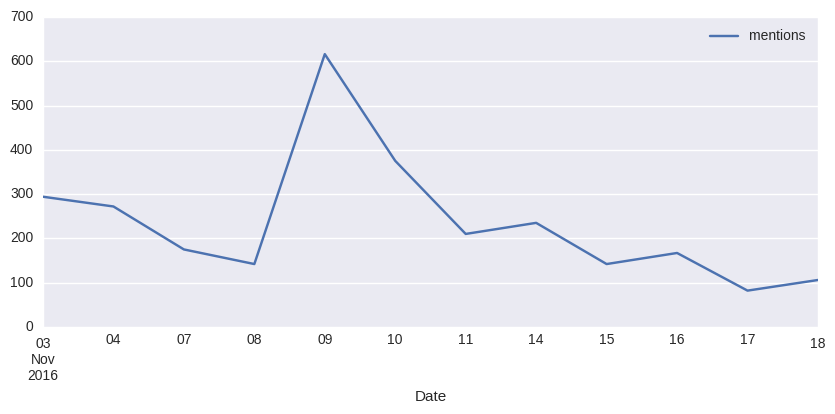

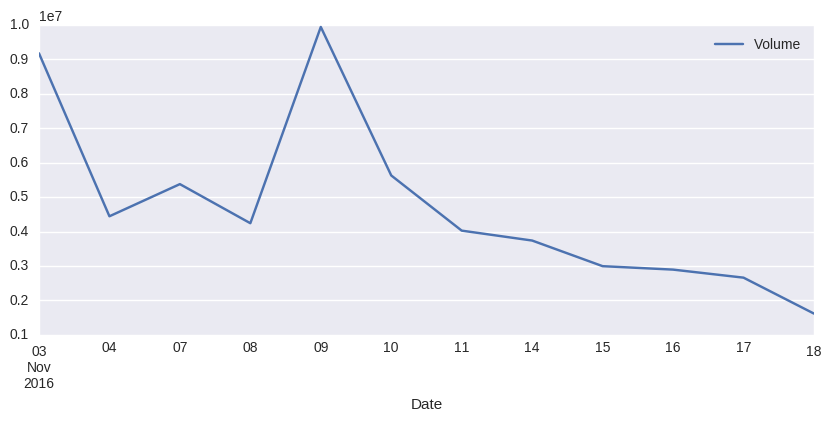

In [203]:
#fig = plt.figure(figsize=(10,4))
#ax = fig.add_subplot(111)
#l1 = ax.plot(stockData['Adj Close'])
stock_metrics[['mentions']].plot(legend=True,figsize=(10,4));
stock_metrics[['Volume']].plot(legend=True,figsize=(10,4));

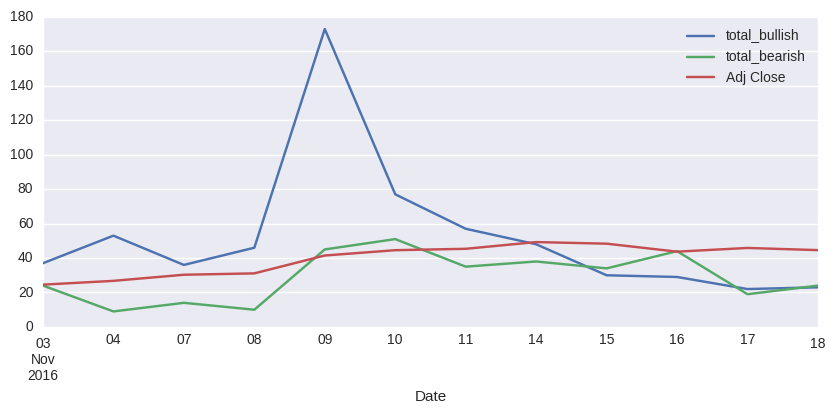

In [204]:
stock_metrics[['total_bullish','total_bearish','Adj Close']].plot(legend=True,figsize=(10,4));

In [138]:
def SaveTwits(filename, db, symbol):
    conn = sqlite3.connect(filename)
    db.to_sql(symbol, conn)
    conn.close()
#fn = 'stocktwits.db'
#SaveTwits(fn, db)